In [6]:
import numpy as np 
from tqdm import tqdm 
import cv2
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from plotly import tools


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping 

In [8]:
#import os
#RANDOM_SEED=123
#IMG_PATH='Brain_Tumor_DataSet/'
#for CLASS in os.listdir(IMG_PATH):
    #if not CLASS.startswith('.'):
        #IMG_NUM=len(os.listdir(IMG_PATH+CLASS)) 
        #for(n,FILE_NAME)in enumerate(os.listdir(IMG_PATH+CLASS)):
            #img=IMG_PATH+CLASS+'/'+FILE_NAME
            #if n<600:
                #shutil.copy(img,'TEST/'+CLASS.upper()+'/'+FILE_NAME)
            #elif n<0.8*IMG_NUM:
                #shutil.copy(img,'TRAIN/'+CLASS.upper()+'/'+FILE_NAME)
            #else:
                #shutil.copy(img,'VAL/'+CLASS.upper()+'/'+FILE_NAME)

In [9]:
import os
import shutil

# Définition des variables
RANDOM_SEED = 123
IMG_PATH = 'Brain_Tumor_DataSet/'

# Création des répertoires de destination s'ils n'existent pas déjà

#os.makedirs('TEST', exist_ok=True)
#os.makedirs('TRAIN', exist_ok=True)
#os.makedirs('VAL', exist_ok=True)

# Parcours des classes dans le répertoire IMG_PATH
#for CLASS in os.listdir(IMG_PATH):
    #if not CLASS.startswith('.'):
        # Création du répertoire de la classe dans les répertoires TEST, TRAIN et VAL
        #os.makedirs('TEST/' + CLASS.upper(), exist_ok=True)
        #os.makedirs('TRAIN/' + CLASS.upper(), exist_ok=True)
        #os.makedirs('VAL/' + CLASS.upper(), exist_ok=True)
        
        # Obtention du nombre d'images dans la classe
        #IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        
        # Parcours des images dans la classe
        
        #for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            #img = IMG_PATH + CLASS + '/' + FILE_NAME
            
            # Copie des cinq premières images dans le répertoire TEST
            #if n < 500:
                #shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            # Copie des images restantes dans le répertoire TRAIN ou VAL
            #elif n < 0.8 * IMG_NUM:
                #shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            #else:
                #shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME)


In [10]:
import os
import cv2
from tqdm import tqdm

def load_data(dir_path, img_size=(100, 100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(cv2.resize(img, img_size))
                    y.append(i)
            i += 1  
    X = np.array(X) 
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [11]:
def plot_confusion_matrix(cm,classes,normalize=False,title='confusion matrix',cmap=plt.cm.Blues):
    plt.figure(figsize=(6,6))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=90)
    plt.yticks(tick_marks,classes)
    if normalize:
        cm =cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    thresh =cm.max()/2.
    cm=np.round(cm,2)
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.show()

In [12]:
TRAIN_DIR='TRAIN/'
TEST_DIR='TEST/'
VAL_DIR='VAL/'
IMG_SIZE=(224,224)

X_train,y_train,labels=load_data(TRAIN_DIR,IMG_SIZE)
X_test,y_test,_=load_data(TEST_DIR,IMG_SIZE)
X_val,y_val,_=load_data(VAL_DIR,IMG_SIZE)

y=dict()
y[0]=[]
y[1]=[]
for set_name in(y_train,y_val,y_test):
    y[0].append(np.sum(set_name==0))
    y[1].append(np.sum(set_name==1))

100%|██████████| 2/2 [00:33<00:00, 16.77s/it]


3616 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


991 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]

884 images loaded from VAL/ directory.


In [13]:
trace0=go.Bar(
x=['Train Set','Validation Set','Test Set'],y=y[0], name='No',marker=dict(color='#33cc33'),opacity=0.7)
trace1=go.Bar(
x=['Train Set','Validation Set','Test Set'],y=y[1], name='Yes',marker=dict(color='#ff3300'),opacity=0.7)
data=[trace0,trace1]
layout=go.Layout(title='Count of classes in each set',xaxis={'title':'Set'},yaxis={'title':'Count'})
fig=go.Figure(data,layout)
iplot(fig)

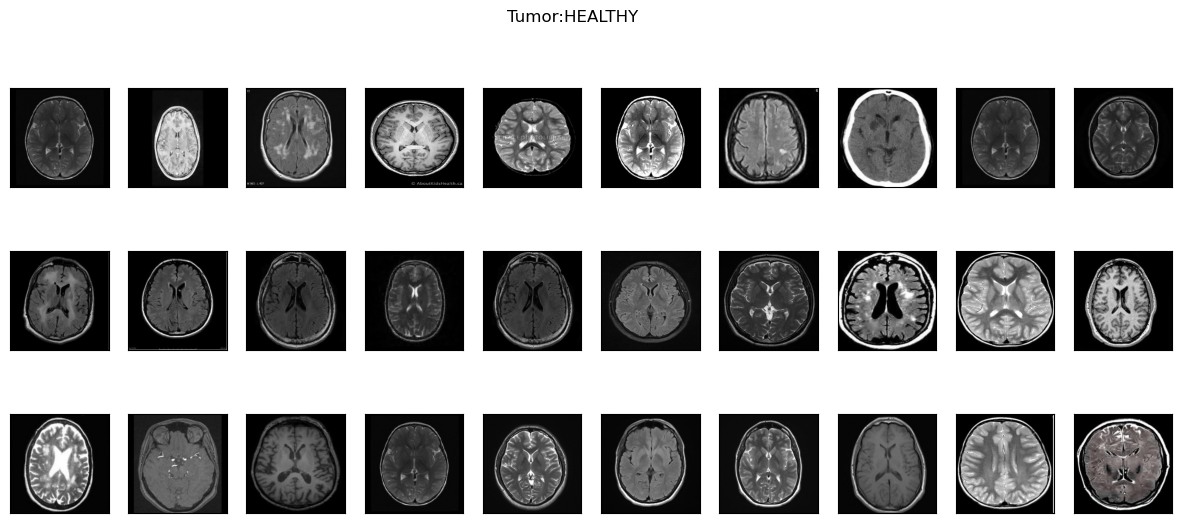

In [14]:
def plot_samples(X,y,labels_dict,n=50):
    for index in range(len(labels_dict)):
        imgs=X[np.argwhere(y==index)][:n]
        j=10
        i=int(n/j)
        plt.figure(figsize=(15,6))
        c=1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])
            
            plt.xticks([])
            plt.yticks([])
            c+=1
        plt.suptitle('Tumor:{}'.format(labels_dict[index]))
        plt.show()
        
plot_samples(X_train,y_train,labels,30)
        
            

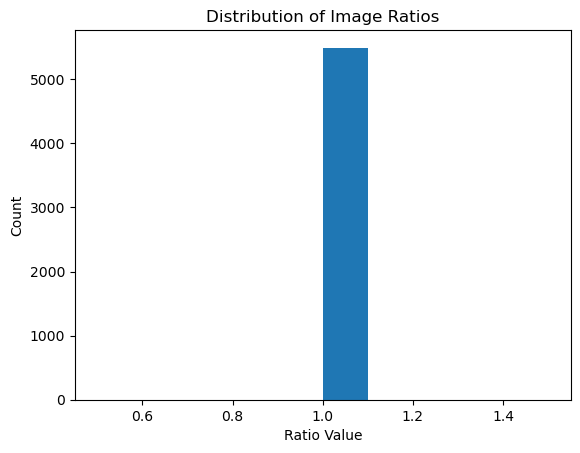

In [15]:
RATIO_LIST=[]
for set in (X_train,X_test,X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1] / img.shape[0])
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [16]:
def crop_imgs(set_name, add_pixels_value=0, img_size=(100, 100)):
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, img_size)  # Redimensionner l'image
        set_new.append(new_img)
    
    return np.array(set_new)


In [17]:
# Load the image
img = cv2.imread('Brain_Tumor_DataSet/Healthy/Not Cancer  (100).jpg')

# Check if the image is loaded correctly
if img is None:
    print("Error: Unable to load the image.")
else:
    new_width = 224  # Example width
    new_height = 224  # Example height
    # Define your desired image size for resizing
    IMG_SIZE = (new_width, new_height)

    # Resize the image
    resized_img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur (gray, (5, 5), 0)

    thresh = cv2.threshold (gray, 45, 255, cv2.THRESH_BINARY) [1]
    thresh = cv2.erode (thresh, None, iterations=2)
    thresh = cv2.dilate (thresh, None, iterations=2)

    cnts = cv2.findContours (thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts =imutils.grab_contours (cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:,:, 0].argmin()][0])
    extRight = tuple(c[c[:,:, 0].argmax()][0]) 
    extTop= tuple(c[c[:,:, 1].argmin()][0])
    extBot = tuple(c[c[:,:, 1].argmax()][0])

    img_cnt=cv2.drawContours(img.copy(),[c],-1,(0,255,255),4)
    img_pnt=cv2.circle(img_cnt.copy(),extLeft,8,(0,0,255),-1)
    img_pnt=cv2.circle(img_pnt,extRight,8,(0,255,0),-1)
    img_pnt=cv2.circle(img_pnt,extTop,8,(255,0,0),-1)
    img_pnt=cv2.circle(img_pnt,extBot,8,(255,255,0),-1)

    ADD_PIXELS=0
    new_img = img[extTop[1]-ADD_PIXELS:extBot [1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    plt.figure(figsize=(15,6))
    plt.subplot(141)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title('step 1.Get the original image')
    plt.subplot(142)
    plt.imshow(img_cnt)
    plt.xticks([])
    plt.yticks([])
    plt.title('step 2.Find the biggest contour')
    plt.subplot(143)
    plt.imshow(img_pnt)
    plt.xticks([])
    plt.yticks([])
    plt.title('step 3.Find the extreme points')
    plt.subplot(144)
    plt.imshow(new_img)
    plt.xticks([])
    plt.yticks([])
    plt.title('step 4.Crop the image')
    plt.show()


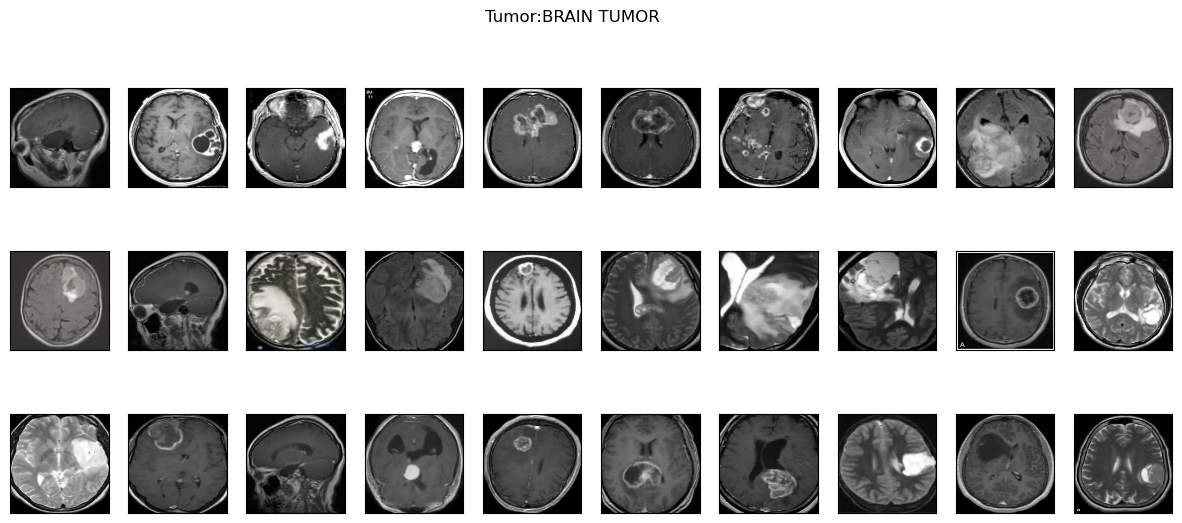

In [18]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop=crop_imgs(set_name=X_val)
X_test_crop=crop_imgs(set_name=X_test) 

plot_samples(X_train_crop,y_train,labels,30)

In [19]:
import cv2
import os
import tempfile

def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            class_folder = 'Brain Tumor/'
        else:
            class_folder = 'Healthy/'

        # Créer le dossier de destination s'il n'existe pas
        dest_folder = os.path.join(folder_name, class_folder)
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        # Créer un fichier temporaire pour l'image
        temp_filename = tempfile.NamedTemporaryFile(suffix='.jpg', delete=False).name

        # Sauvegarder l'image temporaire
        cv2.imwrite(temp_filename, img)

        # Extraire l'extension de fichier du fichier temporaire
        _, ext = os.path.splitext(temp_filename)

        # Générer un nom de fichier unique
        new_filename = os.path.join(dest_folder, str(i) + '_' + str(imclass) + ext)

        # S'assurer que le nom de fichier est unique
        while os.path.exists(new_filename):
            i += 1
            new_filename = os.path.join(dest_folder, str(i) + '_' + str(imclass) + ext)

        # Déplacer l'image temporaire vers le dossier de destination avec le nom correct
        os.rename(temp_filename, new_filename)

        i += 1

# Utilisation de la fonction pour sauvegarder les images
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

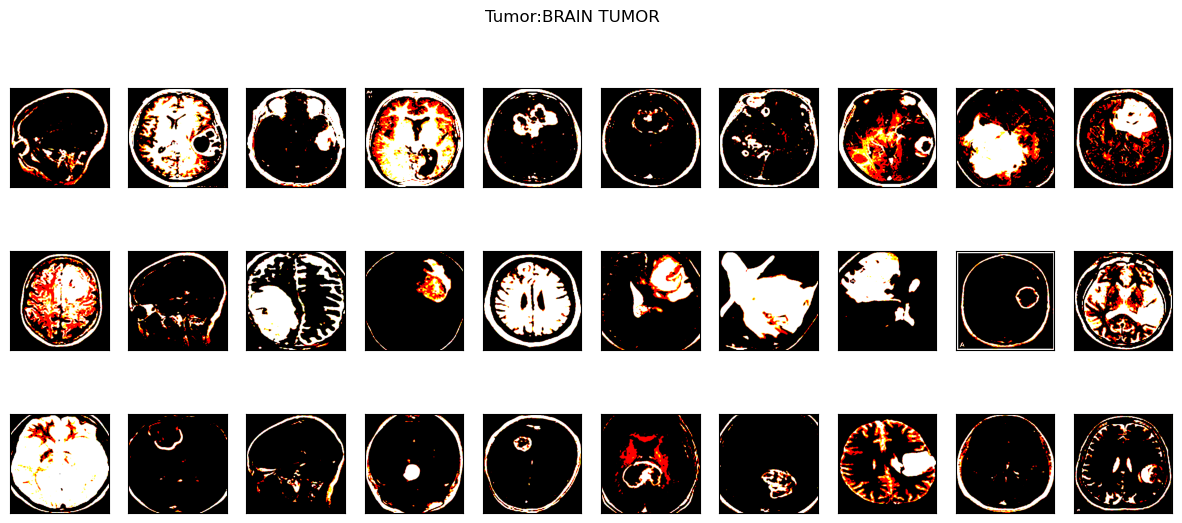

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

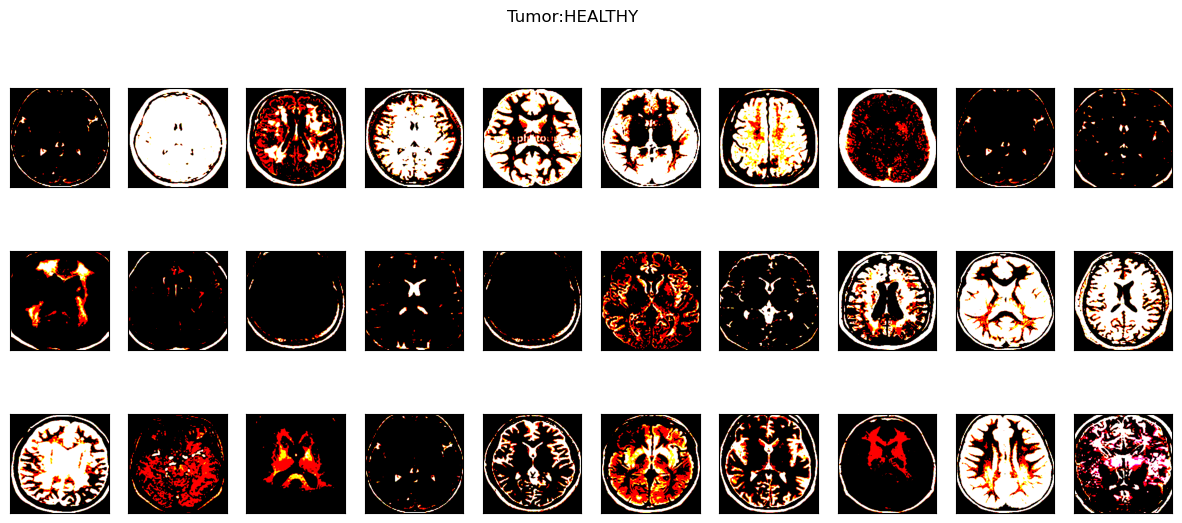

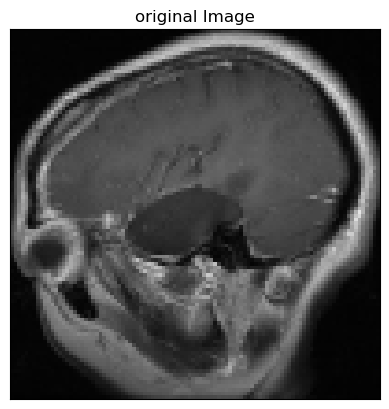

In [20]:
#resize img to (224,224) needed for vgg-16
#augmentation img
def preprocess_imgs(set_name,img_size):
    set_new=[]
    for img in set_name:
        img=cv2.resize(img,dsize=img_size,interpolation=cv2.INTER_CUBIC)
        img = preprocess_input(img)
        set_new.append(img)
    return np.array(set_new)
X_train_prep=preprocess_imgs(set_name=X_train_crop,img_size=IMG_SIZE)
X_test_prep=preprocess_imgs(set_name=X_test_crop,img_size=IMG_SIZE)
X_val_prep=preprocess_imgs(set_name=X_val_crop,img_size=IMG_SIZE)

plot_samples(X_train_prep,y_train,labels,30)


demo_datagen=ImageDataGenerator(rotation_range=15,width_shift_range=0.05,height_shift_range=0.05,rescale=1./255,shear_range=0.05,brightness_range=[0.1,1.5],horizontal_flip=True,vertical_flip=True)
#os.mkdir('preview')
x=X_train_crop[0]
x=x.reshape((1,)+x.shape)

i=0
for batch in demo_datagen.flow(x,batch_size=1,save_to_dir='preview',save_prefix='aug_img',save_format='jpg'):
    i+=1
    if i>20:
        break
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('original Image')
plt.show()

In [21]:
plt.figure(figsize=(15,6))
i=1
for img in os.listdir('preview/'):
    img=cv2.imread('preview/'+img)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i+=1
    if i>3*7:
        break
        
plt.suptitle('Augemented Images')
plt.show()

In [22]:
TRAIN_DIR='TRAIN_CROP/'
VAL_DIR='VAL_CROP/'
train_datagen=ImageDataGenerator(rotation_range=15,width_shift_range=0.01,height_shift_range=0.01,shear_range=0.01,brightness_range=[0.5,1.5],horizontal_flip=True,vertical_flip=True,preprocessing_function=preprocess_input)
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)


In [23]:
RANDOM_SEED = 123
train_generator =train_datagen.flow_from_directory(TRAIN_DIR,color_mode='rgb',target_size=IMG_SIZE,batch_size=32,class_mode='binary',seed=RANDOM_SEED)
validation_generator =test_datagen.flow_from_directory(VAL_DIR,color_mode='rgb',target_size=IMG_SIZE,batch_size=16,class_mode='binary',seed=RANDOM_SEED)

Found 25422 images belonging to 2 classes.
Found 6258 images belonging to 2 classes.


In [24]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint

# Définir la taille de l'image en entrée
IMG_SIZE = (224, 224)




# Charger le modèle VGG16 avec les poids à partir du fichier spécifié
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=vgg16_weight_path, include_top=False, input_shape=IMG_SIZE+(3,))

NUM_CLASSES = 1
model = Sequential() 
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
model.layers[0].trainable = False

# Définition de l'optimiseur avec le taux d'apprentissage spécifié
optimizer = RMSprop(learning_rate=1e-4)

# Définir le chemin pour enregistrer les poids du modèle avec l'extension .keras
checkpoint_path = 'modele_entrene.{epoch:02d}-{val_accuracy:.2f}.keras'

# Créer un callback pour sauvegarder les poids du modèle
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')


# Compiler le modèle avec l'optimiseur spécifié
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()
EPOCHS = 10
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=6)


# Entraîner le modèle en utilisant la méthode fit
history = model.fit(train_generator, steps_per_epoch=50, epochs=EPOCHS,
                    validation_data=validation_generator, validation_steps=25,
                    callbacks=[es])


# Sauvegarder le modèle après l'entraînement
#model.save('modele_entrene.h5')


# plot model performance


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


C:\Users\nour2\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



50/50 ━━━━━━━━━━━━━━━━━━━━ 7528s 151s/step - accuracy: 0.5909 - loss: 4.5979 - val_accuracy: 0.6500 - val_loss: 4.9618
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6801s 137s/step - accuracy: 0.7153 - loss: 2.9938 - val_accuracy: 0.6675 - val_loss: 4.6802
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7471s 151s/step - accuracy: 0.7585 - loss: 2.2285 - val_accuracy: 0.6475 - val_loss: 6.4676
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6377s 128s/step - accuracy: 0.8023 - loss: 1.8128 - val_accuracy: 0.6600 - val_loss: 5.8252
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6531s 132s/step - accuracy: 0.8337 - loss: 1.5205 - val_accuracy: 0.7175 - val_loss: 3.7828
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7518s 150s/step - accuracy: 0.8383 - loss: 1.3639 - val_accuracy: 0.6725 - val_loss: 5.4418
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6052s 121s/step - accuracy: 0.8531 - loss: 1.2643 - val_accuracy: 0.7600 - val_loss: 3.6273
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10719s 217s/step - accuracy: 0.8532 - loss: 1.2814 - val_accura

ValueError: Unable to synchronously create dataset (name already exists)

In [27]:
import os

# Supprimer le fichier existant s'il existe
if os.path.exists('modele_entrene.h5'):
    os.remove('modele_entrene.h5')

# Sauvegarder le modèle après l'entraînement
model.save('nouveau_modele_entrene.keras')





In [29]:
# plot model performance


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)


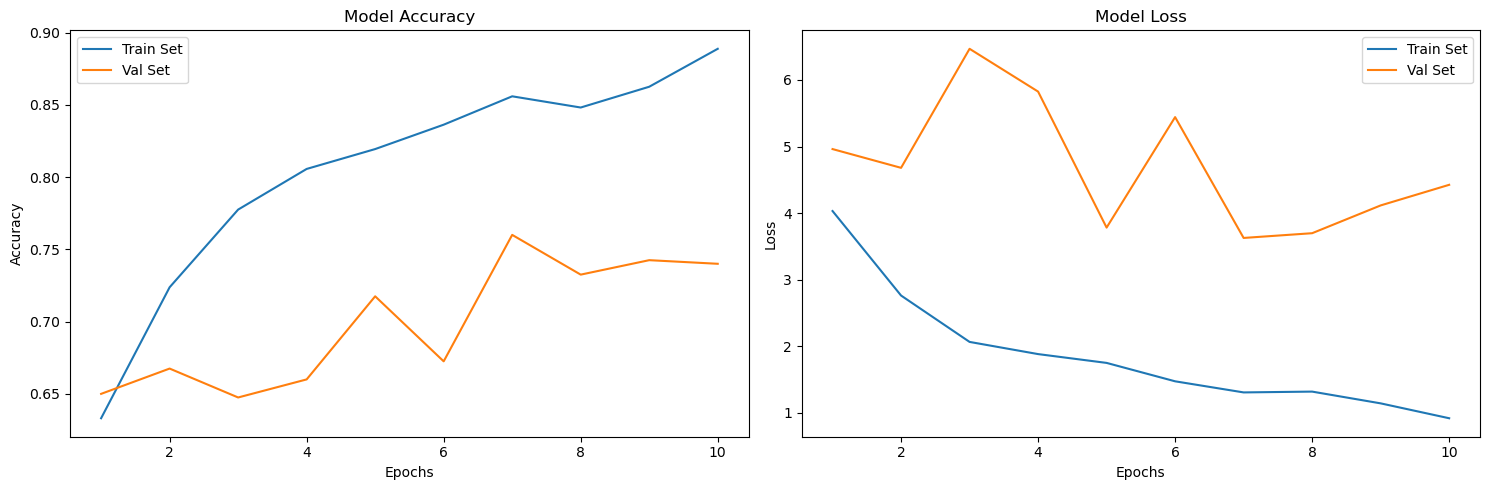

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set') 
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend (loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set') 
plt.plot(epochs_range, val_loss, label='Val Set') 
plt.legend (loc= "best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 2474s 88s/step
Val Accuracy = 0.90


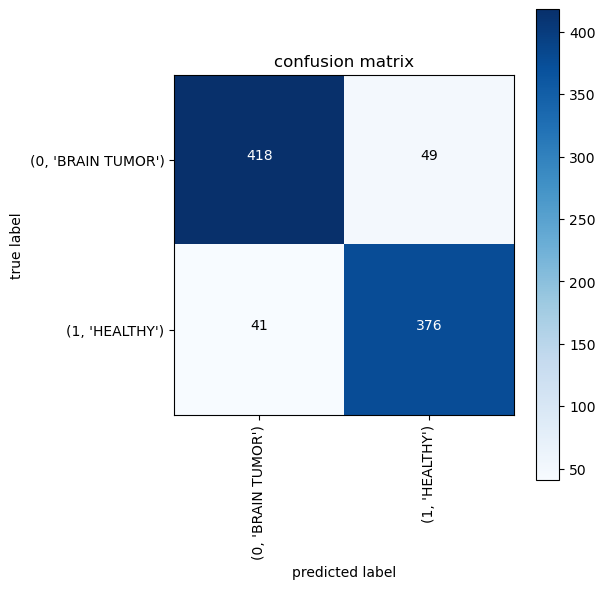

31/31 ━━━━━━━━━━━━━━━━━━━━ 3043s 98s/step
Test Accuracy = 0.91


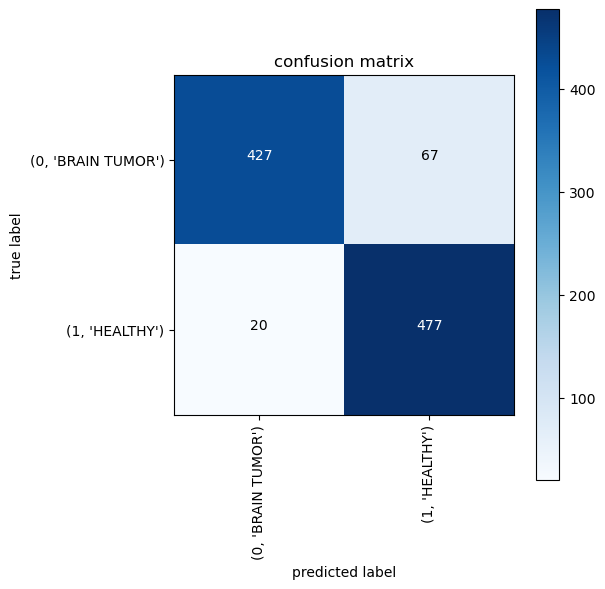

In [31]:

predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy =accuracy_score (y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)
confusion_mtx = confusion_matrix (y_val, predictions)
cm = plot_confusion_matrix (confusion_mtx, classes = list(labels.items()), normalize=False)

predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy = accuracy_score (y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)
confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix (confusion_mtx, classes = list(labels.items()), normalize=False)